<a href="https://colab.research.google.com/github/thisarli/VAE-PyTorch-implementation/blob/main/VAE_PyTorch_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and imports

In [ ]:
!pip install -q torch torchvision altair seaborn
from pathlib import Path
import tqdm

In [ ]:
import os
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
WORKING_ENV = 'COLAB'

from google.colab import drive
%load_ext google.colab.data_table
content_path = '/content/drive/MyDrive/dl_cw_2'
data_path = './data/'
drive.mount('/content/drive/')

content_path = Path(content_path)

Mounted at /content/drive/


In [ ]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'VAE/'):
    os.makedirs(content_path/'VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# Setup GPU
GPU = True 
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


# VAE Implementation

In [ ]:
# Hyperparameters 
num_epochs = 20
learning_rate = 0.0001
batch_size =  64
latent_dim =  8
capacity = 64 # easy to access hyperparameter to change the complexity of the model
beta = 1.5 

# Input transformation to Tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

### Data loading


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=capacity, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(capacity),
            nn.ReLU(),
            nn.Conv2d(in_channels=capacity, out_channels=capacity*2, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(capacity*2),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(in_features=capacity*2*7*7, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=capacity*2*7*7, out_features=latent_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=capacity*2, out_channels=capacity, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(capacity),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=capacity, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.fc_upsize = nn.Linear(in_features=latent_dim, out_features=capacity*2*7*7)
        
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1) 
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar
    
    def reparametrize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        z = self.fc_upsize(z)
        z = z.view(z.size(0), capacity*2, 7, 7)
        z = self.decoder(z)
        return z
    
    def forward(self, x):
        x_mu, x_logvar = self.encode(x)
        z = self.reparametrize(x_mu, x_logvar)
        reconstructed = self.decode(z)

        return reconstructed, x_mu, x_logvar

model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 421777
VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=6272, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=6272, out_features=8, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
  (fc_upsize): Linear(in_features=8, out_features=6272, bias=True)
)


# Load MNIST dataset

In [ ]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'VAE/image_original.png')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## VAE loss implementation (reconstruction + KL loss)

In [ ]:
# function to get test_loss

def test_loss(beta, model):
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    with torch.no_grad():
        for data, _ in loader_test:
            data = data.to(device)
            data_recon, mu, logvar = model(data)
            
            loss, recon_loss, kl_loss = loss_function_VAE(data_recon, data, mu, logvar, beta)
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

        
    total_loss /= len(loader_test.dataset)
    total_recon_loss /= len(loader_test.dataset)
    total_kl_loss /= len(loader_test.dataset)
    print("kl",total_kl_loss)

    return total_loss, total_recon_loss, total_kl_loss

# function to get training loss

def loss_function_VAE(recon_x, x, mu, logvar, beta):
  recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return recon_loss + beta * kl_loss, recon_loss, kl_loss

# Training the model

In [ ]:
model.train()

train_vae_loss_list = []
train_recon_loss_list = []
train_kl_loss_list = []

test_vae_loss_list = []
test_recon_loss_list = []
test_kl_loss_list = []

for epoch in range(num_epochs):

    if epoch > 0:
      train_vae_loss_list.append(train_vae/len(loader_train.dataset))
      train_recon_loss_list.append(train_recon/len(loader_train.dataset))
      train_kl_loss_list.append(train_kl/len(loader_train.dataset))
      print(train_kl_loss_list[-1])

      test_vae_loss, test_recon_loss, test_kl_loss = test_loss(beta, deepcopy(model))

      test_vae_loss_list.append(test_vae_loss)
      test_recon_loss_list.append(test_recon_loss)
      test_kl_loss_list.append(test_kl_loss)

    train_vae = 0
    train_recon = 0
    train_kl = 0

    print(f"-------Epoch {epoch}/{num_epochs}--------")
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for batch_idx, (data, _) in enumerate(tepoch):   

            data = data.to(device)
            data_recon, mu, logvar = model(data)

            loss, recon_loss, kl_loss = loss_function_VAE(data_recon, data, mu, logvar, beta)

            train_vae += loss.item()
            train_recon += recon_loss.item()
            train_kl += kl_loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=loss.item()/len(data))

    if epoch == num_epochs - 1:
        with torch.no_grad():
            torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                content_path/'VAE/VAE_model.pth')


Training started
-------Epoch 0/20--------


Epoch 0: 100%|██████████| 938/938 [00:16<00:00, 57.03batch/s, loss=141]


13.12153885421753
kl 13.097809564208985
-------Epoch 1/20--------


Epoch 1: 100%|██████████| 938/938 [00:16<00:00, 56.89batch/s, loss=134]


13.4053834177653
kl 13.479923974609376
-------Epoch 2/20--------


Epoch 2: 100%|██████████| 938/938 [00:16<00:00, 57.57batch/s, loss=130]


13.507353903706868
kl 13.334915585327149
-------Epoch 3/20--------


Epoch 3: 100%|██████████| 938/938 [00:16<00:00, 57.23batch/s, loss=131]


13.526169449869792
kl 13.430217803955077
-------Epoch 4/20--------


Epoch 4: 100%|██████████| 938/938 [00:16<00:00, 57.06batch/s, loss=130]


13.552271940104166
kl 13.662902340698242
-------Epoch 5/20--------


Epoch 5: 100%|██████████| 938/938 [00:16<00:00, 57.32batch/s, loss=130]


13.61950272878011
kl 13.466166986083984
-------Epoch 6/20--------


Epoch 6: 100%|██████████| 938/938 [00:16<00:00, 57.72batch/s, loss=116]


13.755750862121582
kl 13.989178286743163
-------Epoch 7/20--------


Epoch 7: 100%|██████████| 938/938 [00:16<00:00, 57.43batch/s, loss=120]


13.886551498413086
kl 13.500683001708984
-------Epoch 8/20--------


Epoch 8: 100%|██████████| 938/938 [00:16<00:00, 57.39batch/s, loss=119]


14.017941114298502
kl 13.857825640869141
-------Epoch 9/20--------


Epoch 9: 100%|██████████| 938/938 [00:16<00:00, 57.79batch/s, loss=129]


14.100909690348308
kl 14.265143112182617
-------Epoch 10/20--------


Epoch 10: 100%|██████████| 938/938 [00:16<00:00, 56.94batch/s, loss=116]


14.195764588419596
kl 14.257221264648438
-------Epoch 11/20--------


Epoch 11: 100%|██████████| 938/938 [00:16<00:00, 57.19batch/s, loss=121]


14.276133653767904
kl 14.521532138061524
-------Epoch 12/20--------


Epoch 12: 100%|██████████| 938/938 [00:16<00:00, 57.48batch/s, loss=130]


14.353242922465007
kl 14.79935244140625
-------Epoch 13/20--------


Epoch 13: 100%|██████████| 938/938 [00:16<00:00, 57.06batch/s, loss=114]


14.380045686848959
kl 14.71885768737793
-------Epoch 14/20--------


Epoch 14: 100%|██████████| 938/938 [00:16<00:00, 57.48batch/s, loss=114]


14.454053015136719
kl 14.281523205566407
-------Epoch 15/20--------


Epoch 15: 100%|██████████| 938/938 [00:16<00:00, 56.28batch/s, loss=117]


14.47252473195394
kl 14.484801419067383
-------Epoch 16/20--------


Epoch 16: 100%|██████████| 938/938 [00:16<00:00, 57.49batch/s, loss=120]


14.504138747660319
kl 14.29041909942627
-------Epoch 17/20--------


Epoch 17: 100%|██████████| 938/938 [00:16<00:00, 57.34batch/s, loss=116]


14.551983407592774
kl 14.387272201538085
-------Epoch 18/20--------


Epoch 18: 100%|██████████| 938/938 [00:16<00:00, 56.46batch/s, loss=116]


14.56525655110677
kl 14.322268463134765
-------Epoch 19/20--------


Epoch 19: 100%|██████████| 938/938 [00:16<00:00, 57.89batch/s, loss=122]


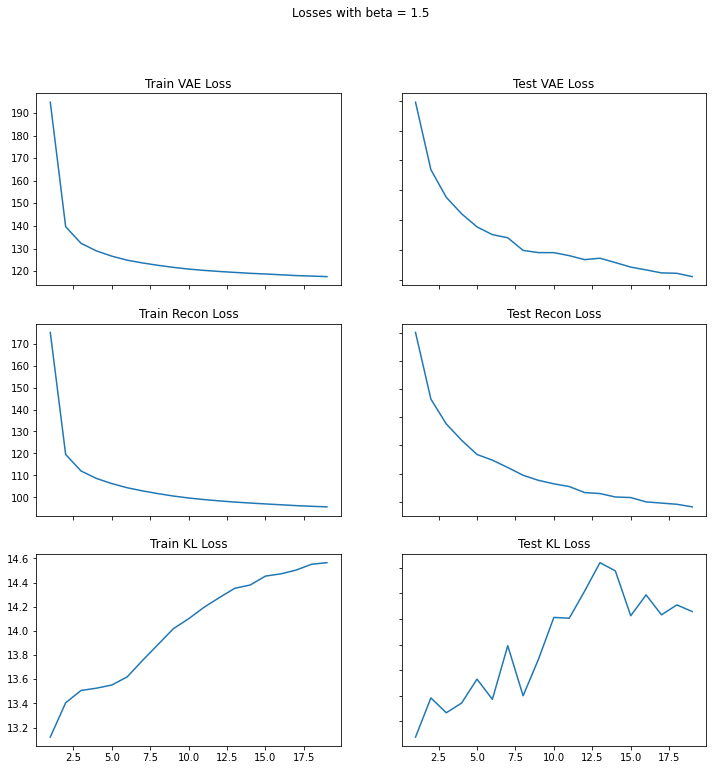

In [ ]:
# Loss curves

x = len(train_vae_loss_list)
x = [i for i in range(1,x+1)]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))
fig.suptitle(f"Losses with beta = {beta}")
ax1.plot(x, train_vae_loss_list)
ax1.set_title("Train VAE Loss")
ax2.plot(x, test_vae_loss_list)
ax2.set_title("Test VAE Loss")
ax3.plot(x, train_recon_loss_list)
ax3.set_title("Train Recon Loss")
ax4.plot(x, test_recon_loss_list)
ax4.set_title("Test Recon Loss")
ax5.plot(x, train_kl_loss_list)
ax5.set_title("Train KL Loss")
ax6.plot(x, test_kl_loss_list)
ax6.set_title("Test KL Loss")

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig(content_path/f"CW_VAE/LOSSES_beta_{beta}.png")